In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp

ds_name = '06032021'
ds_folder = f'../data/{ds_name}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/06032021\cluster_dynamics.csv
../data/06032021\edges.csv
../data/06032021\err_nodes.csv
../data/06032021\new.csv
../data/06032021\new_cluster_dynamics.csv
../data/06032021\split_rs123\test.csv
../data/06032021\split_rs123\train.csv
../data/06032021\split_rs123\valid.csv


In [2]:
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [3]:
#Import the files
node_df = pd.read_csv(f'{ds_folder}/new_cluster_dynamics.csv')
edge_df = pd.read_csv(f'{ds_folder}/edges.csv')

D:\Downloads\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
print('Shape of node data is', node_df.shape)
print ('Shape of edge data is', edge_df.shape)

Shape of node data is (13733047, 19)
Shape of edge data is (13712613, 5)


In [5]:
edge_df.tail()

,from,to,weight1,weight2,sim
13712608,1396,231,12,0.009602,999
13712609,1396,575,12,0.009680,999
13712610,1393,1397,3,0.002858,999
13712611,1397,42,1,0.000948,999
13712612,1397,607,17,0.015876,999


In [6]:
edge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13712613 entries, 0 to 13712612
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   from     int64  
 1   to       int64  
 2   weight1  int64  
 3   weight2  float64
 4   sim      int64  
dtypes: float64(1), int64(4)
memory usage: 523.1 MB


In [7]:
#drop non-node data points
drop_node = np.where(pd.isna(node_df['node'])==True)
node_df = node_df.drop(drop_node[0])
print('Number of dropped node is', len(drop_node[0]))

node_df['sim'] = pd.to_numeric(node_df['sim'])
node_df['dynamic_model'] = pd.to_numeric(node_df['dynamic_model'])

Number of dropped node is 12038


### Count number of trees

In [9]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
#assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 9685


### Error check duplicate number of nodes and edges on a tree
Number of nodes for one tree should equal to number of edges plus 1. 

In [10]:
err_dic = {}
err_treeids = []
for one_tree_id in node_tree_ids:
    onetree_node_df = node_df[node_df['sim'] == one_tree_id] 
    uni_node_sample = onetree_node_df.drop_duplicates()
    uni_node = onetree_node_df.drop_duplicates('node')
    onetree_edge_df = edge_df[edge_df['sim'] == one_tree_id]
    uni_edge_sample = onetree_edge_df.drop_duplicates()
    uni_edge = onetree_edge_df.drop_duplicates(['from','to'])
    if len(uni_node) == len(uni_edge)+1:
        continue
    else:
        err_dic[one_tree_id] = [len(onetree_node_df),len(uni_node_sample),len(uni_node),len(onetree_edge_df),len(uni_edge_sample),len(uni_edge)]
        err_treeids.append(one_tree_id)
        node_df = node_df.drop(node_df[node_df['sim']==one_tree_id].index)
        edge_df = edge_df.drop(edge_df[edge_df['sim']==one_tree_id].index)
#         if len(err_treeids) == 1:
#             err_node_df = onetree_node_df
#             err_edge_df = onetree_edge_df
#         else:
#             err_node_df = err_node_df.append(onetree_node_df)
#             err_edge_df = err_edge_df.append(onetree_edge_df)



In [11]:
print('The id of error tree:')
print(err_treeids)

The id of error tree:
[]


In [12]:
err_df = pd.DataFrame.from_dict(err_dic, orient='index', 
                                columns=["#raw_nodes", 
                                         "#unique_nodes_consider_feats", "#unique_nodes_no_consider_feats", 
                                         "#raw_edges", "#unique_edges_consider_feats", "#unique_edges_no_consider_feats"])
err_df.index.name = "sim"
err_df

,#raw_nodes,#unique_nodes_consider_feats,#unique_nodes_no_consider_feats,#raw_edges,#unique_edges_consider_feats,#unique_edges_no_consider_feats
sim,,,,,,


In [13]:
err_df.to_csv(f"{ds_folder}/duplicate_trees.csv")

print('Number of error tree is',len(err_treeids))
print('For error tree',err_treeids[0])
print(f'Number of node samples: {err_dic[err_treeids[0]][0]}')
print(f'Number of unique node samples: {err_dic[err_treeids[0]][1]}')
print(f'Number of unique nodes: {err_dic[err_treeids[0]][2]}')
print(f'Number of edge samples: {err_dic[err_treeids[0]][3]}')
print(f'Number of unique edge samples: {err_dic[err_treeids[0]][4]}')
print(f'Number of unique edges: {err_dic[err_treeids[0]][5]}')

err_node_df.to_csv(f"{ds_folder}/err_tree_nodes.csv")
err_node_df

In [15]:
for id in edge_tree_ids:
    if id in node_tree_ids:
        continue
    else:
        print(id)

2


In [16]:
edge_df[edge_df['sim']==2]

,from,to,weight1,weight2,sim
8327565,668,669,6,0.005062,2
8327566,669,670,11,0.009525,2
8327567,670,671,5,0.004300,2
8327568,671,672,3,0.002828,2
8327569,672,673,5,0.004389,2
...,...,...,...,...,...
8328849,1289,571,11,0.010801,2
8328850,1289,585,11,0.010517,2
8328851,1286,1290,19,0.018272,2
8328852,1290,86,10,0.008464,2


In [17]:
edge_df = edge_df.drop(edge_df[edge_df['sim']==2].index)

In [18]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 9685


In [19]:
print('Shape of node data is', node_df.shape)
print('Shape of edge data is', edge_df.shape)

Shape of node data is (13721009, 19)
Shape of edge data is (13711324, 5)


### Analysis the edge weights

In [20]:
aly_edge_feat_cols = ['weight1', 'weight2']
aly_edge_df = edge_df[aly_edge_feat_cols]

In [21]:
aly_edge_df.describe()

,weight1,weight2
count,1.371132e+07,1.371132e+07
mean,1.158920e+01,1.043065e-02
std,9.449977e+00,8.549155e-03
min,0.000000e+00,0.000000e+00
25%,4.000000e+00,3.749864e-03
50%,9.000000e+00,8.192930e-03
75%,1.700000e+01,1.509248e-02
max,1.060000e+02,8.970773e-02


array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>]], dtype=object)

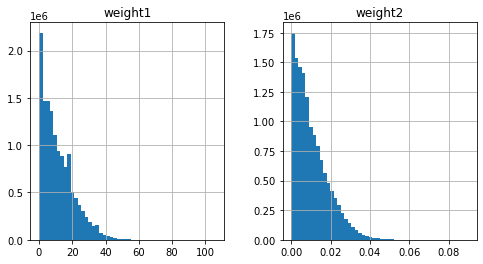

In [22]:
aly_edge_df.hist(bins=50,figsize=(8,4))

In [23]:
# Compute pairwise correlation of columns (pearson R: standard correlation coefficient)
aly_edge_df.corr()

,weight1,weight2
weight1,1.000000,0.994886
weight2,0.994886,1.000000


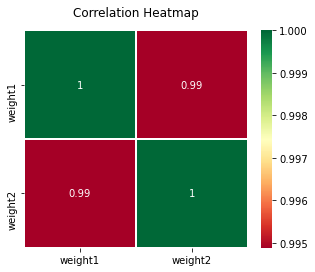

In [24]:
# Pearson Correlation Matrix

# Increase the size of the heatmap.
plt.figure(figsize=(5, 4))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_edge_df.corr(), annot=True, linewidths=.5, cmap="RdYlGn")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', pad=14);

### Get the node and edge distribution of the trees

In [25]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 9685


In [26]:
from collections import defaultdict

tree_dist_dict = defaultdict(list)

for tree_id in tree_ids:
    tree_dist_dict['sim'].append(tree_id)
    onetree_node_df = node_df[node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    tree_dist_dict['num_nodes'].append(num_nodes)
    
    #num_background_nodes = onetree_node_df[onetree_node_df['cluster_id']=='Background'].shape[0]
    #tree_dist_dict['num_background_nodes'].append(num_background_nodes)
    #tree_dist_dict[f'rat_background_nodes'].append(num_background_nodes / num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        tree_dist_dict[f'num_{label}_nodes'].append(num_label_nodes)
        tree_dist_dict[f'rat_{label}_nodes'].append(num_label_nodes / num_nodes)
        
    onetree_edge_df = edge_df[edge_df['sim'] == tree_id]
    # print(onetree_edge_df.shape)
    tree_dist_dict['num_edges'].append(onetree_edge_df.shape[0])
    
tree_dist_df = pd.DataFrame.from_dict(tree_dist_dict)

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>],
       [<AxesSubplot:title={'center':'rat_static_nodes'}>,
        <AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'rat_growth_nodes'}>],
       [<AxesSubplot:title={'center':'num_decay_nodes'}>,
        <AxesSubplot:title={'center':'rat_decay_nodes'}>,
        <AxesSubplot:title={'center':'num_edges'}>]], dtype=object)

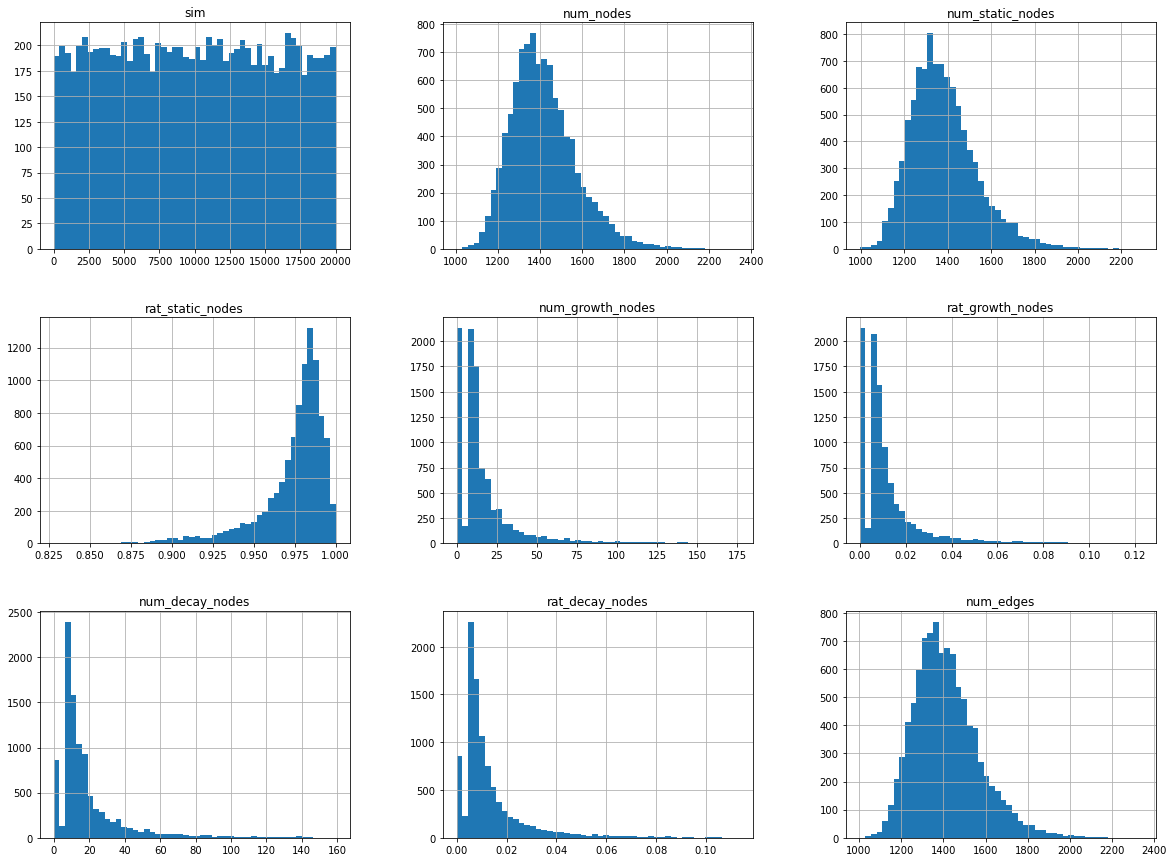

In [27]:
tree_dist_df.hist(bins=50,figsize=(20,15))

### Split the train/test sets

In [28]:
random_seed = 123
np.random.seed(random_seed)
split_folder = f'../data/{ds_name}/split_rs{random_seed}'
os.makedirs(split_folder, exist_ok=True)

from sklearn.model_selection import  train_test_split
#split the data for training and testing
train_ids, test_ids = train_test_split(tree_ids, test_size=0.2)
print(f"Train: {len(train_ids)}, Test: {len(test_ids)}")
print(test_ids[:10])

Train: 7748, Test: 1937
[18905 13921 15041  2500  4130  6861  8934  5555  6858  8026]


In [29]:
train_edge_df = edge_df[edge_df['sim'].isin(train_ids)]
test_edge_df = edge_df[edge_df['sim'].isin(test_ids)]

print(f'Train edges: {train_edge_df.shape[0]}')
print(f'Test edges: {test_edge_df.shape[0]}')

Train edges: 10973761
Test edges: 2737563


### Normalize the edge weights

array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>]], dtype=object)

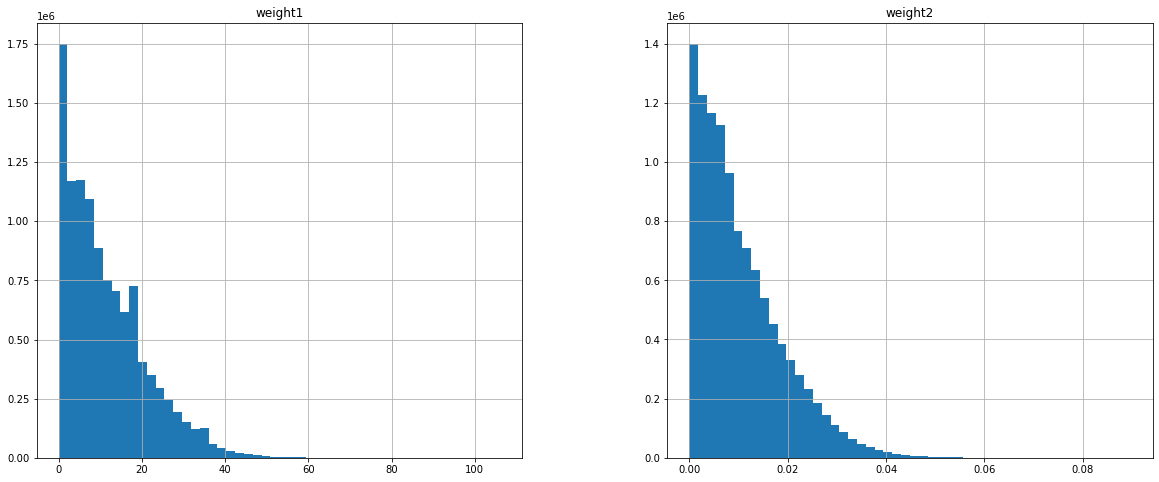

In [30]:
train_edge_df[aly_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [31]:
train_edge_df['weight1'].describe()

count    1.097376e+07
mean     1.158858e+01
std      9.448234e+00
min      0.000000e+00
25%      4.000000e+00
50%      9.000000e+00
75%      1.700000e+01
max      1.060000e+02
Name: weight1, dtype: float64

In [32]:
train_edge_df.loc[:, 'weight1_arsinh'] = np.arcsinh(train_edge_df['weight1'])

In [33]:
train_edge_df['weight2'].describe()

count    1.097376e+07
mean     1.043007e-02
std      8.547599e-03
min      0.000000e+00
25%      3.751486e-03
50%      8.193434e-03
75%      1.508991e-02
max      8.970773e-02
Name: weight2, dtype: float64

In [34]:
train_edge_df.loc[:, 'weight2_arsinh'] = np.arcsinh(train_edge_df['weight2'])

array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>],
       [<AxesSubplot:title={'center':'weight1_arsinh'}>,
        <AxesSubplot:title={'center':'weight2_arsinh'}>]], dtype=object)

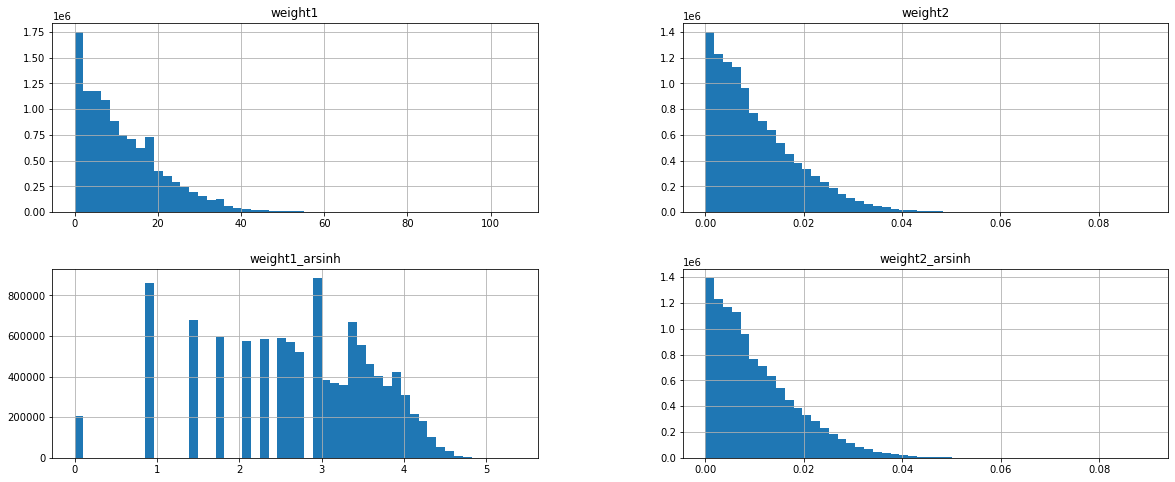

In [35]:
aly_edge_feat_cols += ['weight1_arsinh', 'weight2_arsinh']

train_edge_df[aly_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [36]:
from sklearn import preprocessing

# Standardization edge features
std_scaler = preprocessing.StandardScaler().fit(train_edge_df[aly_edge_feat_cols])
norm_num_feat_cols = [f'{col_name}-norm' for col_name in aly_edge_feat_cols]

norm_train_vals = std_scaler.transform(train_edge_df[aly_edge_feat_cols])
norm_train_edge_df = pd.DataFrame(norm_train_vals, columns=norm_num_feat_cols, index=train_edge_df.index)
train_edge_df = pd.concat([train_edge_df, norm_train_edge_df], axis=1)

In [37]:
train_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
0,651,652,5,0.004204,10000,2.312438,0.004204,-0.697335,-0.728425,-0.433586,-0.728462
1,652,653,1,0.000820,10000,0.881374,0.000820,-1.120694,-1.124340,-1.859741,-1.124440
2,653,654,3,0.002780,10000,1.818446,0.002780,-0.909015,-0.894972,-0.925883,-0.895036
3,654,1,5,0.004050,10000,2.312438,0.004050,-0.697335,-0.746376,-0.433586,-0.746416
4,654,655,3,0.002427,10000,1.818446,0.002427,-0.909015,-0.936319,-0.925883,-0.936389
...,...,...,...,...,...,...,...,...,...,...,...
13712608,1396,231,12,0.009602,999,3.179785,0.009602,0.043544,-0.096912,0.430785,-0.096864
13712609,1396,575,12,0.009680,999,3.179785,0.009680,0.043544,-0.087716,0.430785,-0.087667
13712610,1393,1397,3,0.002858,999,1.818446,0.002858,-0.909015,-0.885919,-0.925883,-0.885981
13712611,1397,42,1,0.000948,999,0.881374,0.000948,-1.120694,-1.109314,-1.859741,-1.109411


In [38]:
print(std_scaler.mean_, std_scaler.scale_)

[1.15885816e+01 1.04300693e-02 2.74751711e+00 1.04293769e-02] [9.44823388e+00 8.54759853e-03 1.00344247e+00 8.54622575e-03]


In [39]:
# Update the feat_dict.json
import json

js_f = osp.join('./feat_dict0603.json')

with open(js_f, 'r') as infile:
    feat_dict = json.load(infile)

feat_dict['raw_edge_feats'] = aly_edge_feat_cols
feat_dict['norm_edge_feats'] = [f'{org_feat_col}-norm' for org_feat_col in aly_edge_feat_cols]

node_feat_cols = feat_dict['norm_onehot_feats']
raw_edge_feat_cols = feat_dict['raw_edge_feats']
norm_edge_feat_cols = feat_dict['norm_edge_feats']

print(f'Inputs: {len(node_feat_cols)}, {node_feat_cols}')
label_feat_col = 'dynamic_cat'

with open(js_f, 'w') as outfile:
    json.dump(feat_dict, outfile, sort_keys=True, indent=4)

Inputs: 19, ['v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'new_R0-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']


In [40]:
test_edge_df.loc[:, 'weight1_arsinh'] = np.arcsinh(test_edge_df['weight1'])
test_edge_df.loc[:, 'weight2_arsinh'] = np.arcsinh(test_edge_df['weight2'])
test_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh
3892,748,1,2,0.001943,10004,1.443635,0.001943
3893,748,749,4,0.003538,10004,2.094713,0.003538
3894,749,750,2,0.001968,10004,1.443635,0.001968
3895,750,751,6,0.005759,10004,2.491780,0.005758
3896,751,752,9,0.008228,10004,2.893444,0.008228
...,...,...,...,...,...,...,...
13699840,1167,35,4,0.003640,9981,2.094713,0.003640
13699841,1167,89,14,0.013862,9981,3.333478,0.013862
13699842,1164,1168,6,0.005729,9981,2.491780,0.005729
13699843,1168,58,18,0.017806,9981,3.584290,0.017805


In [41]:
norm_test_vals = std_scaler.transform(test_edge_df[raw_edge_feat_cols])
norm_test_edge_df = pd.DataFrame(norm_test_vals, columns=norm_edge_feat_cols, index=test_edge_df.index)
test_edge_df = pd.concat([test_edge_df, norm_test_edge_df], axis=1)

In [42]:
test_edge_df.head()

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
3892,748,1,2,0.001943,10004,1.443635,0.001943,-1.014854,-0.992965,-1.299408,-0.993043
3893,748,749,4,0.003538,10004,2.094713,0.003538,-0.803175,-0.806289,-0.650565,-0.806339
3894,749,750,2,0.001968,10004,1.443635,0.001968,-1.014854,-0.989987,-1.299408,-0.990065
3895,750,751,6,0.005759,10004,2.491780,0.005758,-0.591495,-0.546534,-0.254860,-0.546545
3896,751,752,9,0.008228,10004,2.893444,0.008228,-0.273975,-0.257625,0.145426,-0.257597


array([[<AxesSubplot:title={'center':'weight1-norm'}>,
        <AxesSubplot:title={'center':'weight2-norm'}>],
       [<AxesSubplot:title={'center':'weight1_arsinh-norm'}>,
        <AxesSubplot:title={'center':'weight2_arsinh-norm'}>]],
      dtype=object)

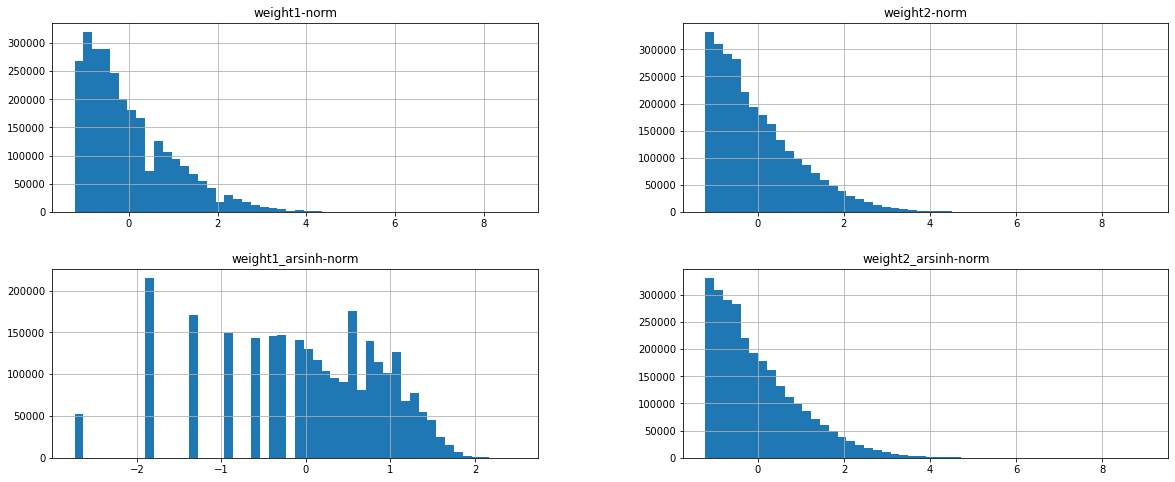

In [43]:
test_edge_df[norm_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [44]:
train_ids, valid_ids = train_test_split(train_ids, test_size=0.25)
print(f"Train: {len(train_ids)}, Valid: {len(valid_ids)}")
print(valid_ids[:10])

Train: 5811, Valid: 1937
[ 5766 18451   638 18095  9284  2699  3806 10162 16601 13857]


In [45]:
train_full_df = train_edge_df[train_edge_df['sim'].isin(train_ids)]
valid_full_df = train_edge_df[train_edge_df['sim'].isin(valid_ids)]

print(f'Train edge: {train_full_df.shape[0]}')
print(f'Valid edge: {valid_full_df.shape[0]}')
train_full_df.head()

Train edge: 8222962
Valid edge: 2750799


,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
0,651,652,5,0.004204,10000,2.312438,0.004204,-0.697335,-0.728425,-0.433586,-0.728462
1,652,653,1,0.000820,10000,0.881374,0.000820,-1.120694,-1.124340,-1.859741,-1.124440
2,653,654,3,0.002780,10000,1.818446,0.002780,-0.909015,-0.894972,-0.925883,-0.895036
3,654,1,5,0.004050,10000,2.312438,0.004050,-0.697335,-0.746376,-0.433586,-0.746416
4,654,655,3,0.002427,10000,1.818446,0.002427,-0.909015,-0.936319,-0.925883,-0.936389


In [46]:
# Save the train/test to the disk

train_full_df.to_csv(f'{split_folder}/train_edge.csv', index=False)
valid_full_df.to_csv(f'{split_folder}/valid_edge.csv', index=False)
test_edge_df.to_csv(f'{split_folder}/test_edge.csv', index=False)

### Build a tree with DGL

In [47]:
import networkx as nx
import matplotlib.pyplot as plt

In [48]:
# Load a tree from the train data
train_node_df = pd.read_csv(f'{split_folder}/train.csv')
vis_tree_id = train_ids[0]
print(vis_tree_id)

6261


In [49]:
onetree_node_df = train_node_df[train_node_df['sim'] == vis_tree_id] 
onetree_edge_df = train_edge_df[edge_df['sim'] == vis_tree_id]

<ipython-input-49-44110b4dfc21>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  onetree_edge_df = train_edge_df[edge_df['sim'] == vis_tree_id]


In [50]:
onetree_node_df.head()

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
906020,6261,c1,A,static,0.0,0.466541,89.0,44.0,0.013943,55.007245,...,0.335964,1.514178,2.130277,0.98041,-0.004706,-0.615829,0.025622,-0.552205,0.764355,0.002056
906021,6261,c1,A,static,0.0,0.466541,89.0,44.0,0.013943,55.007245,...,0.335964,1.514178,2.130277,0.98041,-0.004706,-0.615829,0.025622,-0.552205,0.764355,0.002056
906022,6261,c1,A,static,0.0,0.466541,89.0,44.0,0.013943,55.007245,...,0.335964,1.514178,2.130277,0.98041,-0.004706,-0.615829,0.025622,-0.552205,0.764355,0.002056
906023,6261,c1,A,static,0.0,0.466541,89.0,44.0,0.013943,55.007245,...,0.335964,1.514178,2.130277,0.98041,-0.004706,-0.615829,0.025622,-0.552205,0.764355,0.002056
906024,6261,c1,A,static,0.0,0.466541,89.0,44.0,0.013943,55.007245,...,0.335964,1.514178,2.130277,0.98041,-0.004706,-0.615829,0.025622,-0.552205,0.764355,0.002056


In [51]:
onetree_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
10859379,707,708,4,0.003203,6261,2.094713,0.003203,-0.803175,-0.845452,-0.650565,-0.845507
10859380,708,709,7,0.006256,6261,2.644121,0.006256,-0.485655,-0.488320,-0.103042,-0.488322
10859381,709,710,2,0.001843,6261,1.443635,0.001843,-1.014854,-1.004644,-1.299408,-1.004725
10859382,710,711,1,0.000951,6261,0.881374,0.000951,-1.120694,-1.108946,-1.859741,-1.109043
10859383,711,712,25,0.022375,6261,3.912423,0.022373,1.419463,1.397447,1.160909,1.397534
...,...,...,...,...,...,...,...,...,...,...,...
10860736,1362,98,2,0.001736,6261,1.443635,0.001736,-1.014854,-1.017169,-1.299408,-1.017252
10860737,1362,674,8,0.007023,6261,2.776472,0.007023,-0.379815,-0.398585,0.028856,-0.398575
10860738,1358,1363,14,0.012412,6261,3.333478,0.012412,0.255224,0.231860,0.583950,0.231941
10860739,1363,387,10,0.008616,6261,2.998223,0.008616,-0.168135,-0.212208,0.249846,-0.212173


In [38]:
import dgl
import networkx as nx
import torch
import pygraphviz as pgv

Using backend: pytorch


In [39]:
src_ids = torch.tensor(onetree_edge_df['from'].values)
dst_ids = torch.tensor(onetree_edge_df['to'].values)

# Note: the start idx of the node is 0 not 1. But simulation node starts with 1
# We need substract 1 to the node idx for edges and nodes files.
src_ids -= 1
dst_ids -= 1

In [40]:
g = dgl.graph((src_ids, dst_ids))
nx_g = dgl.to_networkx(g)

print(f'Nodes: {g.number_of_nodes()}')
print(f'Edges: {g.number_of_edges()}')

Nodes: 1315
Edges: 1314


In [41]:
g.nodes()

tensor([   0,    1,    2,  ..., 1312, 1313, 1314])

### Assign features to nodes

In [42]:
sorted_onetree_node_df = onetree_node_df.sort_values(by='node')
print(sorted_onetree_node_df['node'].values)
n_nodes = sorted_onetree_node_df.shape[0]
sorted_onetree_node_df.tail()

[1.000e+00 2.000e+00 3.000e+00 ... 1.313e+03 1.314e+03 1.315e+03]


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,dynamic_model-norm
2776512,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109
2776552,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109
2776566,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109
2776537,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109
2776564,Background,3765,Background,static,0.0,0.057632,603,93.0,-16.267842,93.00347,...,0.366479,0.366477,-0.005099,0.129753,-0.005487,-1.431102,0.00655,0.260329,-0.014596,-0.109


<AxesSubplot:>

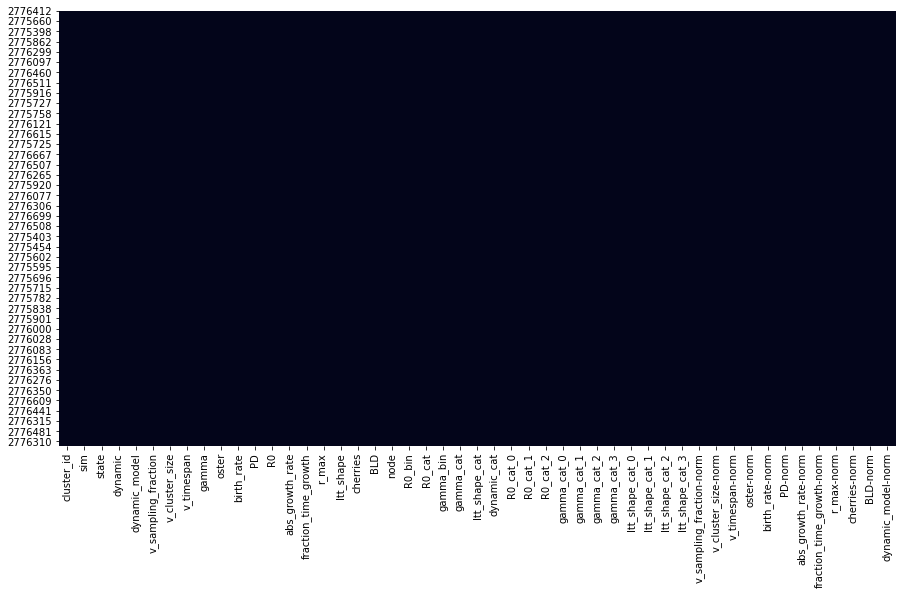

In [43]:
# Now using heatmaps
plt.figure(figsize=(15,8))
sns.heatmap(sorted_onetree_node_df.isnull(), cbar=False)

<AxesSubplot:>

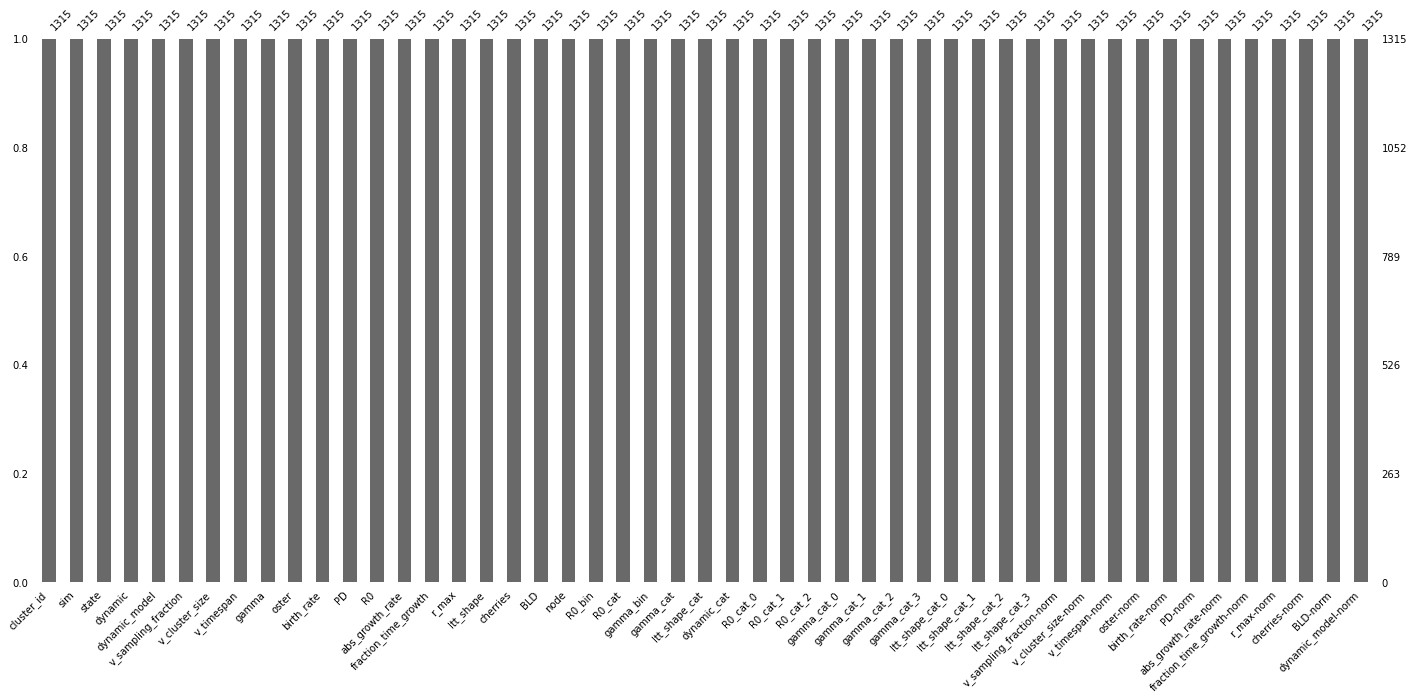

In [44]:
# Next is to use the missingno library to analyze the missing values
import missingno as msno 

msno.bar(sorted_onetree_node_df,labels=True,fontsize=10) 

In [45]:
g.ndata['feat'] = torch.tensor(sorted_onetree_node_df[node_feat_cols].values)
g.ndata['label'] = torch.tensor(sorted_onetree_node_df[label_feat_col].values)

for i in range(n_nodes):
    if not torch.all(torch.isnan(g.ndata['feat'][i])):
        print(f"NodeID: {i+1}, {g.ndata['feat'][i]}, {g.ndata['label'][i]}")
        break

NodeID: 1, tensor([-0.3804,  0.2226,  0.3665,  0.3665, -0.0051,  0.1298, -0.0055, -1.4311,
         0.0066,  0.2603, -0.0146, -0.1090,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000],
       dtype=torch.float64), 2


### Assign features to edges

In [46]:
g.edges()

(tensor([ 679,  680,  681,  ..., 1312, 1314, 1314]),
 tensor([ 680,  681,  682,  ..., 1314,  394,  653]))

In [47]:
# The edge features are assigned to the edata according to the edge order, not considerring the src and dst
g.edata['feat'] = torch.tensor(onetree_edge_df[norm_edge_feat_cols].values)
g.edata['feat'][0]

tensor([0.4636, 0.5841, 0.7149, 0.5842], dtype=torch.float64)

defaultdict(<function <lambda> at 0x7fb6e8cb5048>, {2: 1294, 0: 12, 1: 9})


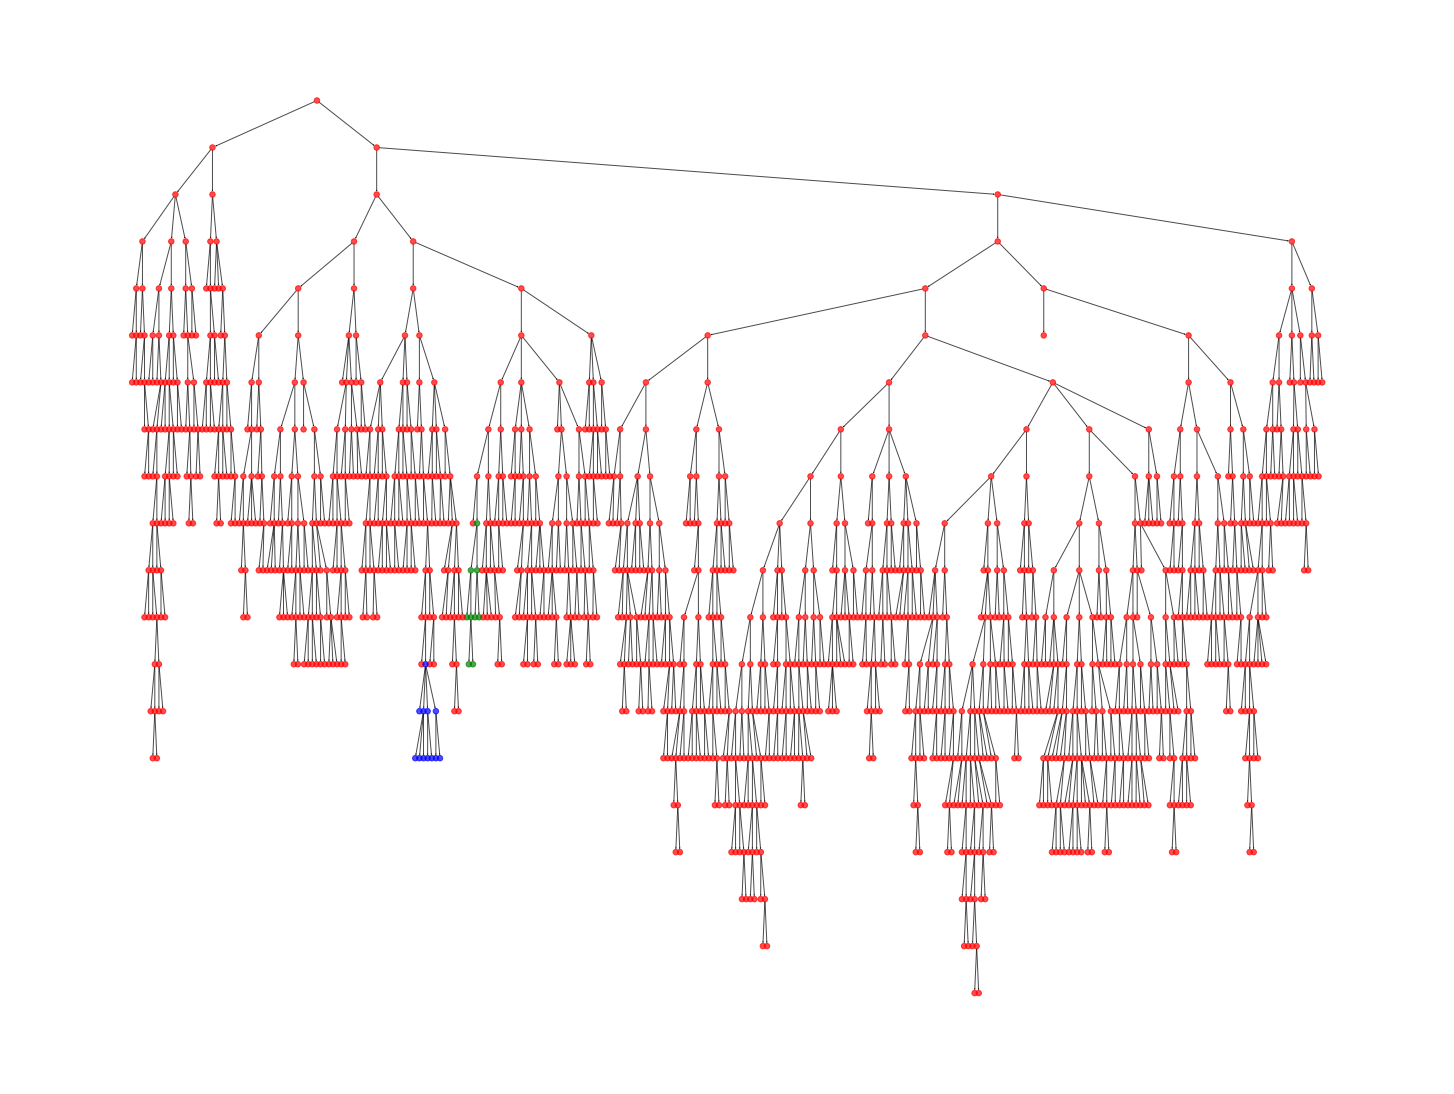

In [49]:
plt.figure(figsize=(20, 15))
color_map = []
node_labels = g.ndata['label'].numpy()
label_counter = defaultdict(lambda: 0)

for node_id in nx_g:
    node_label = node_labels[node_id]
    if np.isnan(node_label):
        label_counter['bg'] += 1
        color_map.append('gray')
    else:
        if node_label == 0:  # decay
            color_map.append('blue')
        elif node_label == 1:   # growth
            color_map.append('green')
        elif node_label == 2:   # static
            color_map.append('red')
        label_counter[node_label] += 1
            
print(label_counter)
pos = nx.nx_agraph.graphviz_layout(nx_g, prog='dot')
nx.draw(nx_g, pos, with_labels=False, node_size=30, node_color=color_map, alpha=.7, arrowsize=1)